In [ ]:
# CELL 1 - imports si setari

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_classes = len(class_names)
img_size = 48

In [2]:
# CELL 2 - incarcare si preprocesare FER2013

csv_path = "../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv"

df = pd.read_csv(csv_path)
print(df.shape)
df.head()

def df_to_numpy(df_part):
    pixels = df_part["pixels"].str.split().tolist()
    X = np.asarray(pixels, dtype="float32")
    X = X.reshape(-1, img_size, img_size, 1) / 255.0
    y = df_part["emotion"].values
    return X, y

train_df = df[df["Usage"] == "Training"]
val_df   = df[df["Usage"] == "PublicTest"]
test_df  = df[df["Usage"] == "PrivateTest"]

X_train, y_train = df_to_numpy(train_df)
X_val,   y_val   = df_to_numpy(val_df)
X_test,  y_test  = df_to_numpy(test_df)

y_train_cat = to_categorical(y_train, num_classes)
y_val_cat   = to_categorical(y_val,   num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)

X_train.shape, X_val.shape, X_test.shape

(35887, 3)


((28709, 48, 48, 1), (3589, 48, 48, 1), (3589, 48, 48, 1))

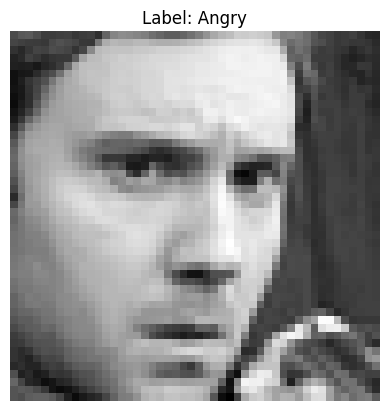

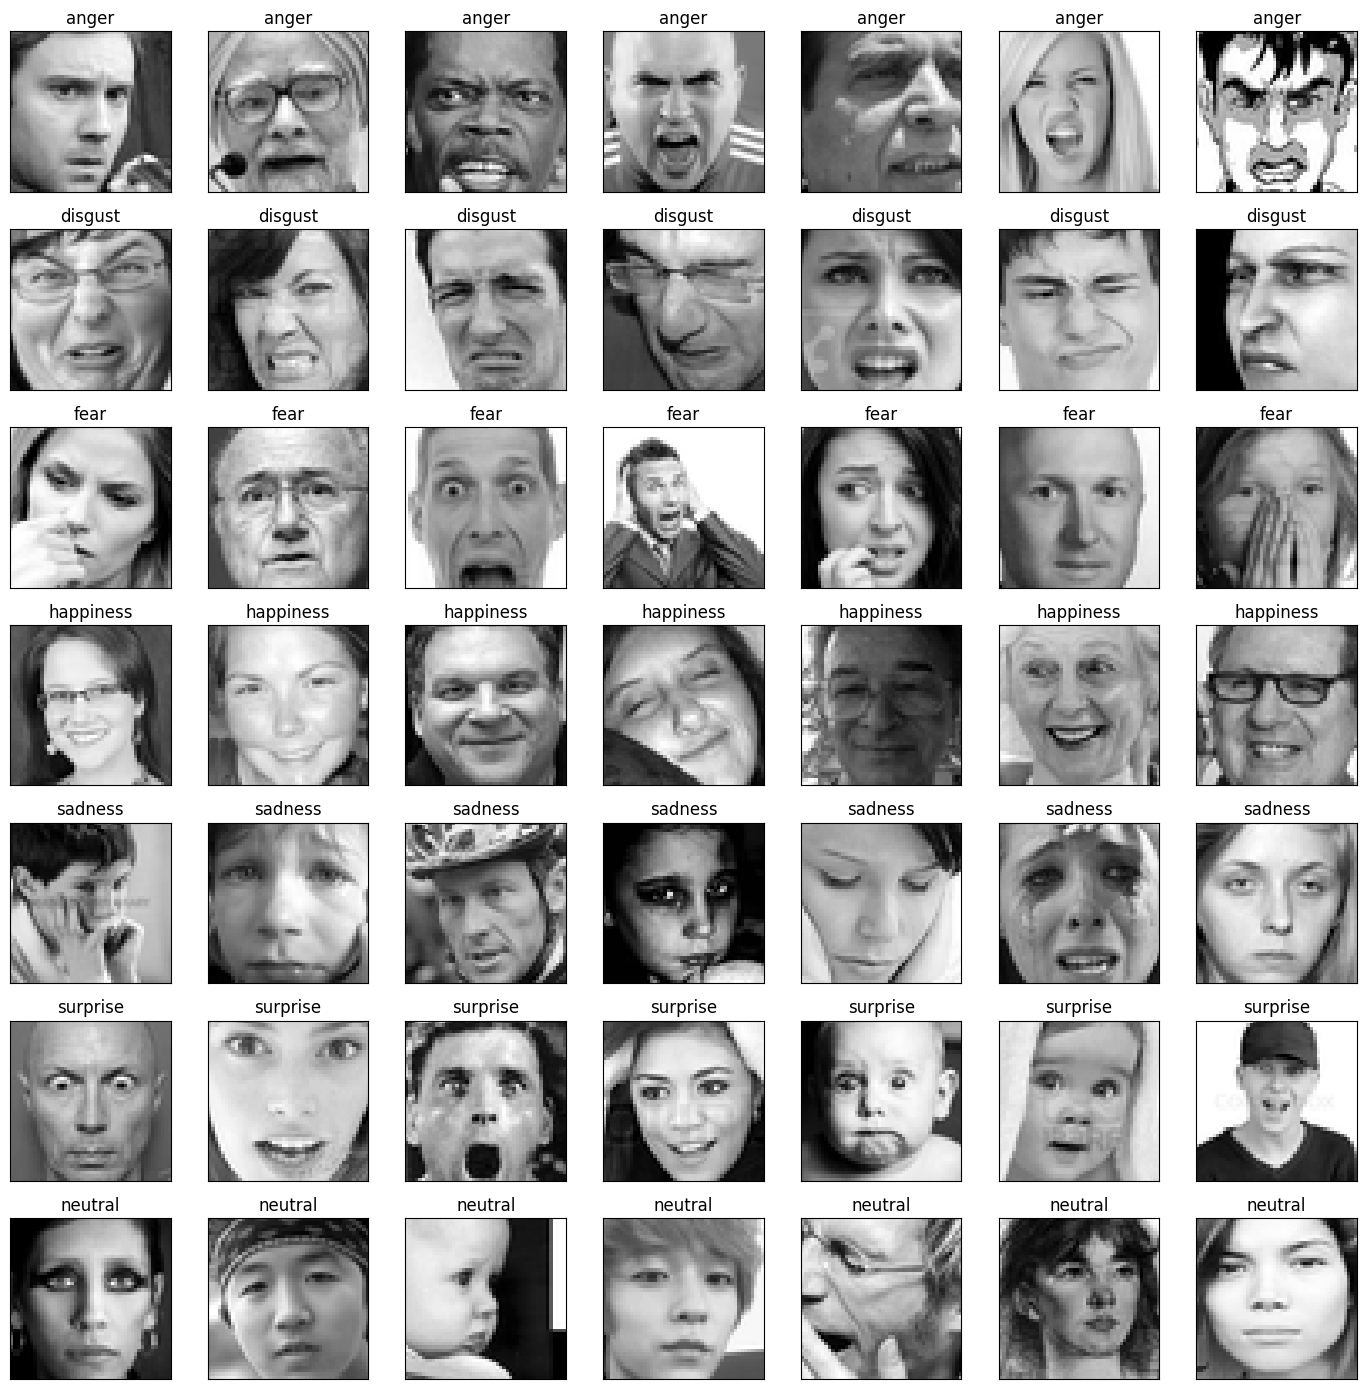

In [3]:
# CELL 3 - sanity check imagine

idx = 0
plt.imshow(X_train[idx, :, :, 0], cmap="gray")
plt.title(f"Label: {class_names[y_train[idx]]}")
plt.axis("off")
plt.show()

df.emotion.unique()

emotion_label_to_text = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

df.emotion.value_counts()

math.sqrt(len(df.pixels.iloc[0].split(' ')))

fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    df_label = df[df.emotion == label].reset_index(drop=True)
    for j in range(7):
        px = df_label.pixels.iloc[j]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
plt.tight_layout()
plt.show()

In [18]:
# CELL 4 - model CNN de baza

def build_cnn(input_shape=(48, 48, 1), num_classes=7):
    model = models.Sequential([

        layers.Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(1024, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

baseline_model = build_cnn()
baseline_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,597,319 (40.43 MB)

 Trainable params: 10,593,479 (40.41 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [5]:
# CELL 5 - antrenare sau incarcare model

import os

model_path = "baseline_cnn.h5"

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.15
)
datagen.fit(X_train)

if os.path.exists(model_path):
    print(f"Loading existing model: {model_path}")
    baseline_model = tf.keras.models.load_model(model_path)
else:
    print("Starting training with Data Augmentation...")
    history = baseline_model.fit(
        datagen.flow(X_train, y_train_cat, batch_size=64),
        validation_data=(X_val, y_val_cat),
        epochs=35
    )
    baseline_model.save(model_path)
    print("Model saved.")

# grafice train / val
if "history" in globals():
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"],     label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"],     label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

Loading existing model: baseline_cnn.h5


In [19]:
# CELL 6 - evaluare pe test (clean)

test_loss, test_acc = baseline_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test clean - loss: {test_loss:.4f} | accuracy: {test_acc * 100:.2f}%")

Test clean - loss: 1.9420 | accuracy: 12.23%


In [7]:
# CELL 7 - helper afisare clean vs adversarial

def decode_prediction(pred_vec):
    return class_names[np.argmax(pred_vec)]

def show_original_and_adversarial(model, x, y_onehot, x_adv, title_clean="Clean", title_adv="Adversarial"):
    pred_clean = model.predict(x,     verbose=0)[0]
    pred_adv   = model.predict(x_adv, verbose=0)[0]

    true_label  = decode_prediction(y_onehot[0])
    clean_label = decode_prediction(pred_clean)
    adv_label   = decode_prediction(pred_adv)

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(x[0, :, :, 0], cmap="gray")
    plt.title(f"{title_clean}\ntrue: {true_label}\npred: {clean_label}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(x_adv[0, :, :, 0], cmap="gray")
    plt.title(f"{title_adv}\npred: {adv_label}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

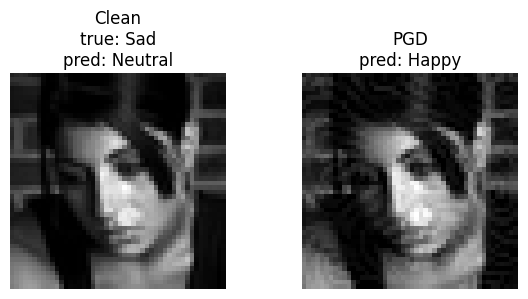

In [8]:
# CELL 8 - PGD attack

loss_object = tf.keras.losses.CategoricalCrossentropy()

def pgd_attack(model, x, y, epsilon=0.03, alpha=0.007, num_iter=40):
    x_orig = tf.cast(x, tf.float32)
    x_adv  = tf.identity(x_orig)
    y_true = tf.cast(y, tf.float32)

    for _ in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            predictions = model(x_adv, training=False)
            loss = loss_object(y_true, predictions)
        gradient    = tape.gradient(loss, x_adv)
        signed_grad = tf.sign(gradient)
        x_adv       = x_adv + alpha * signed_grad
        x_adv       = tf.clip_by_value(x_adv, x_orig - epsilon, x_orig + epsilon)
        x_adv       = tf.clip_by_value(x_adv, 0.0, 1.0)

    return x_adv

# exemplu imagine PGD
idx = np.random.randint(0, X_test.shape[0])
x = X_test[idx:idx+1]
y = y_test_cat[idx:idx+1]

x_pgd = pgd_attack(baseline_model, x, y, epsilon=0.03, alpha=0.007, num_iter=40)
show_original_and_adversarial(baseline_model, x, y, x_pgd, title_adv="PGD")

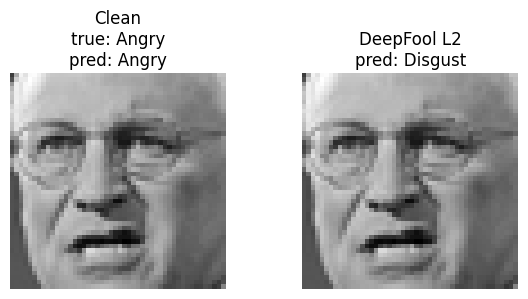

In [9]:
# CELL 9 - DeepFool L2

import numpy as np
import tensorflow as tf

def deepfool_l2(model, x0, num_classes=None, overshoot=0.02, max_iter=55, epsilon=1e-4):
    x0 = tf.cast(x0, tf.float32)
    if len(x0.shape) == 3:
        x0 = tf.expand_dims(x0, axis=0)
    x = tf.identity(x0)

    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x, training=False)[0]
        logits_np = logits.numpy()

    if num_classes is None or num_classes > logits_np.shape[0]:
        num_classes = logits_np.shape[0]

    I = np.argsort(logits_np)[::-1][:num_classes]
    label = int(I[0])

    r_tot = tf.zeros_like(x)
    k_i = label
    loop_i = 0

    while k_i == label and loop_i < max_iter:
        with tf.GradientTape() as tape:
            tape.watch(x)
            logits = model(x, training=False)[0]
            logits_I = tf.gather(logits, I)

        grads = tape.jacobian(logits_I, x)
        grads = tf.squeeze(grads, axis=1)

        grad_orig = grads[0]
        f_i = logits_I.numpy()

        pert_min = np.inf
        w_min = None

        for k in range(1, num_classes):
            w_k = grads[k] - grad_orig
            f_k = float(f_i[k] - f_i[0])

            w_k_flat = tf.reshape(w_k, (-1,))
            w_norm = float(tf.norm(w_k_flat).numpy()) + 1e-8
            pert_k = abs(f_k) / w_norm

            if pert_k < pert_min:
                pert_min = pert_k
                w_min = w_k

        if (w_min is None) or (not np.isfinite(pert_min)):
            break

        w_flat = tf.reshape(w_min, (-1,))
        w_norm = float(tf.norm(w_flat).numpy()) + 1e-8
        r_i = (pert_min + epsilon) * w_flat / w_norm
        r_i = tf.reshape(r_i, x.shape)

        r_tot = r_tot + tf.cast(r_i, r_tot.dtype)

        x = x0 + (1.0 + overshoot) * r_tot
        x = tf.clip_by_value(x, 0.0, 1.0)

        logits_adv = model(x, training=False)[0]
        k_i = int(tf.argmax(logits_adv).numpy())
        loop_i += 1

    x_adv = x
    return x_adv

def deepfool_attack_batch(model, X, num_classes=None, overshoot=0.02, max_iter=5):
    if isinstance(X, tf.Tensor):
        X_np = X.numpy()
    else:
        X_np = X

    X_adv = np.zeros_like(X_np, dtype=np.float32)
    n = X_np.shape[0]

    for i in range(n):
        x0 = X_np[i:i+1]
        x_adv = deepfool_l2(model, x0,
                            num_classes=num_classes,
                            overshoot=overshoot,
                            max_iter=max_iter)
        X_adv[i] = x_adv.numpy()
        if (i + 1) % 50 == 0:
            print(f"DeepFool {i+1}/{n}")

    return X_adv

# exemplu imagine DeepFool
idx = np.random.randint(0, X_test.shape[0])
x = X_test[idx:idx+1]
y = y_test_cat[idx:idx+1]

x_df = deepfool_l2(baseline_model, x, overshoot=0.02, max_iter=5)
show_original_and_adversarial(baseline_model, x, y, x_df, title_adv="DeepFool L2")

In [20]:
# CELL 10 - evaluare baseline pe subset

subset = 50  # poti mari sau micsora, DeepFool este mai lent
X_sub = X_test[:subset]
y_sub = y_test_cat[:subset]

X_sub_pgd = pgd_attack(baseline_model, X_sub, y_sub,
                       epsilon=0.03, alpha=0.007, num_iter=40)
X_sub_df = deepfool_attack_batch(baseline_model, X_sub,
                                  overshoot=0.02, max_iter=5)

def eval_percent(model, X, y, name):
    loss, acc = model.evaluate(X, y, verbose=0)
    print(f"{name:<25} loss={loss:.4f} | acc={acc * 100:.2f}%")
    return loss, acc

print("=== Baseline model ===")
eval_percent(baseline_model, X_sub,     y_sub, "Clean")
eval_percent(baseline_model, X_sub_pgd, y_sub, "PGD")
eval_percent(baseline_model, X_sub_df,  y_sub, "DeepFool L2")

DeepFool 50/50
=== Baseline model ===
Clean                     loss=1.9428 | acc=10.00%
PGD                       loss=1.9603 | acc=0.00%
DeepFool L2               loss=1.9426 | acc=18.00%


(1.9425698518753052, 0.18000000715255737)

Exemplu PGD vs PGD + Spatial Smoothing (window 3)


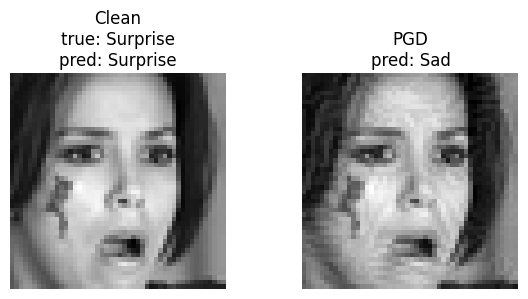

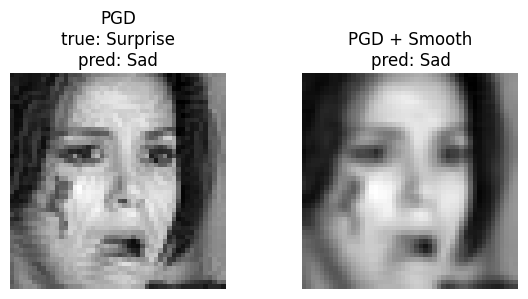

Exemplu DeepFool vs DeepFool + Spatial Smoothing (window 3)


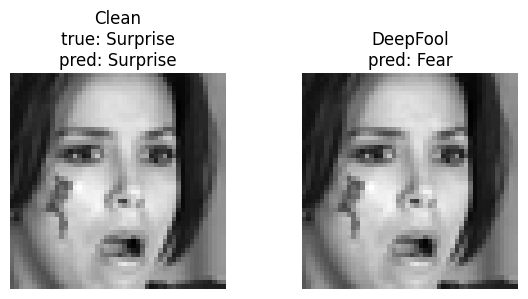

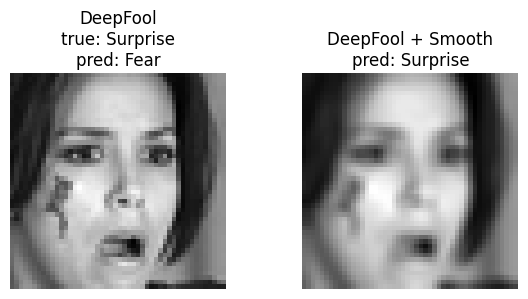

In [11]:
# CELL 11 - defense 1: Feature Squeezing prin Spatial Smoothing

def feature_squeezing_spatial_smoothing(x, window_size=3):
    x = tf.cast(x, tf.float32)

    if window_size is None or window_size <= 1:
        return x

    window_size = int(window_size)

    x_squeezed = tf.nn.avg_pool2d(
        input=x,
        ksize=window_size,
        strides=1,
        padding='SAME'
    )

    return x_squeezed

# exemplu vizual PGD + FS si DeepFool + FS pe o imagine

idx = np.random.randint(0, X_test.shape[0])
x = X_test[idx:idx+1]
y = y_test_cat[idx:idx+1]

param_smooth = 3  # window_size pentru Spatial Smoothing

x_pgd = pgd_attack(baseline_model, x, y,
                   epsilon=0.03, alpha=0.007, num_iter=40)
x_pgd_fs = feature_squeezing_spatial_smoothing(x_pgd, window_size=param_smooth)

x_df = deepfool_l2(baseline_model, x, overshoot=0.02, max_iter=5)
x_df_fs = feature_squeezing_spatial_smoothing(x_df, window_size=param_smooth)

print(f"Exemplu PGD vs PGD + Spatial Smoothing (window {param_smooth})")
show_original_and_adversarial(baseline_model, x,     y, x_pgd,    title_adv="PGD")
show_original_and_adversarial(baseline_model, x_pgd, y, x_pgd_fs, title_clean="PGD", title_adv="PGD + Smooth")

print(f"Exemplu DeepFool vs DeepFool + Spatial Smoothing (window {param_smooth})")
show_original_and_adversarial(baseline_model, x,    y, x_df,    title_adv="DeepFool")
show_original_and_adversarial(baseline_model, x_df, y, x_df_fs, title_clean="DeepFool", title_adv="DeepFool + Smooth")

In [12]:
# CELL 12 - evaluare Feature Squeezing pe subset

window_size = 3

X_sub_pgd_fs = feature_squeezing_spatial_smoothing(X_sub_pgd, window_size=window_size)
X_sub_df_fs  = feature_squeezing_spatial_smoothing(X_sub_df,  window_size=window_size)

print(f"=== Baseline + Feature Squeezing (Spatial Smoothing w={window_size}) ===")

eval_percent(baseline_model, X_sub_pgd_fs, y_sub, f"PGD + FS (Win {window_size})")
eval_percent(baseline_model, X_sub_df_fs,  y_sub, f"DeepFool + FS (Win {window_size})")

=== Baseline + Feature Squeezing (Spatial Smoothing w=3) ===
PGD + FS (Win 3)          loss=1.9264 | acc=38.00%
DeepFool + FS (Win 3)     loss=1.5170 | acc=44.00%


(1.5169934034347534, 0.4399999976158142)

In [ ]:
# CELL 15 - Adversarial Training (PGD + DeepFool)
import os
import time
import numpy as np
import tensorflow as tf

print("Adversarial Training with PGD + DeepFool.")

try:
    base_model = tf.keras.models.load_model(model_path)
    print("Loaded clean model from:", model_path)
except Exception as e:
    print("Warning: could not load model from model_path. Using model in memory if available.")
    base_model = baseline_model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()

ADV_EPOCHS = 20
BATCH_SIZE = 64
STEPS_PER_EPOCH = X_train.shape[0] // BATCH_SIZE

# DeepFool params for training (reduced for speed)
DF_START_EPOCH = 10
DF_MAX_SAMPLES_PER_BATCH = 1
DF_MAX_ITER_TRAIN = 5
DF_OVERSHOOT = 0.02

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
train_dataset = train_dataset.map(
    lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32))
)
train_dataset = train_dataset.shuffle(
    10000, reshuffle_each_iteration=True
).batch(BATCH_SIZE).repeat()
train_iterator = iter(train_dataset)

start_time = time.time()

for epoch in range(ADV_EPOCHS):
    if epoch < 5:
        current_eps = 0.01
        current_iter = 3
    elif epoch < 12:
        current_eps = 0.02
        current_iter = 5
    else:
        current_eps = 0.025
        current_iter = 7

    if epoch == 15:
        optimizer.learning_rate.assign(0.00001)
        print(">> Learning rate dropped for precision.")

    use_deepfool = epoch >= DF_START_EPOCH

    print(f"\nEpoch {epoch + 1}/{ADV_EPOCHS}")
    print(f" -> PGD config: epsilon={current_eps}, num_iter={current_iter}")
    if use_deepfool:
        print(
            f" -> DeepFool active: "
            f"max_df_per_batch={DF_MAX_SAMPLES_PER_BATCH}, "
            f"max_iter={DF_MAX_ITER_TRAIN}"
        )

    for step in range(STEPS_PER_EPOCH):
        x_clean, y_true = next(train_iterator)

        x_clean = tf.cast(x_clean, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        x_pgd = pgd_attack(
            base_model,
            x_clean,
            y_true,
            epsilon=current_eps,
            alpha=0.007,
            num_iter=current_iter
        )

        if hasattr(x_pgd, "numpy"):
            x_pgd = x_pgd.numpy()
        x_pgd = tf.convert_to_tensor(x_pgd, dtype=tf.float32)

        x_parts = [x_clean, x_pgd]
        y_parts = [y_true, y_true]

        if use_deepfool and DF_MAX_SAMPLES_PER_BATCH > 0:
            x_clean_np = x_clean.numpy()
            y_true_np = y_true.numpy()

            batch_size_curr = x_clean_np.shape[0]
            df_count = min(DF_MAX_SAMPLES_PER_BATCH, batch_size_curr)
            idx_df = np.random.choice(batch_size_curr, size=df_count, replace=False)

            x_df_clean = x_clean_np[idx_df]
            y_df = y_true_np[idx_df]

            x_df_adv = deepfool_attack_batch(
                base_model,
                x_df_clean,
                overshoot=DF_OVERSHOOT,
                max_iter=DF_MAX_ITER_TRAIN
            )

            x_df_adv = tf.convert_to_tensor(x_df_adv, dtype=tf.float32)
            y_df = tf.convert_to_tensor(y_df, dtype=tf.float32)

            x_parts.append(x_df_adv)
            y_parts.append(y_df)

        x_combined = tf.concat(x_parts, axis=0)
        y_combined = tf.concat(y_parts, axis=0)

        with tf.GradientTape() as tape:
            logits = base_model(x_combined, training=True)
            loss_value = loss_fn(y_combined, logits)

        grads = tape.gradient(loss_value, base_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, base_model.trainable_variables))

        train_acc_metric.update_state(y_combined, logits)

        if step % 100 == 0:
            print(
                f" Step {step}/{STEPS_PER_EPOCH}: "
                f"loss={loss_value.numpy():.4f}, "
                f"mixed_acc={train_acc_metric.result().numpy():.4f}"
            )

    print(
        f" >> Epoch {epoch + 1} completed. "
        f"Avg mixed acc: {train_acc_metric.result().numpy():.4f}"
    )
    train_acc_metric.reset_state()

total_minutes = (time.time() - start_time) / 60.0
print(f"Adversarial Training finished in {total_minutes:.1f} minutes.")

robust_pro_path = "robust_cnn_adv_pgd_df_pro.h5"
base_model.save(robust_pro_path)
print("Saved robust model to:", robust_pro_path)

In [15]:
# CELL 16 - evaluare model robust (PGD + DeepFool)
print("\n=== Adversarially Trained Model (PGD + DeepFool) ===")

robust_pro_path = "robust_cnn_adv_pgd_df_pro.h5"

robust_model_pro = tf.keras.models.load_model(robust_pro_path)

# PGD attack on subset
X_sub_pgd_pro = pgd_attack(
    robust_model_pro,
    X_sub,
    y_sub,
    epsilon=0.03,
    alpha=0.007,
    num_iter=40
)

# DeepFool attack on subset
X_sub_df_pro = deepfool_attack_batch(
    robust_model_pro,
    X_sub,
    overshoot=0.02,
    max_iter=50
)

eval_percent(robust_model_pro, X_sub, y_sub, "Clean")
eval_percent(robust_model_pro, X_sub_pgd_pro, y_sub, "PGD")
eval_percent(robust_model_pro, X_sub_df_pro, y_sub, "DeepFool L2")


=== Adversarially Trained Model (PGD + DeepFool) ===


DeepFool 50/50
Clean                     loss=1.1145 | acc=54.00%
PGD                       loss=2.0520 | acc=22.00%
DeepFool L2               loss=1.5307 | acc=20.00%


(1.5307495594024658, 0.20000000298023224)

In [25]:
# CELL 17 - Instalare si setup Foolbox (implementari oficiale atacuri)

!pip install -q foolbox==3.3.4

import foolbox as fb
import os

def fb_to_numpy(x, dtype="float32"):
    """Converteste outputurile Foolbox (EagerPy / TF) in np.array."""
    if hasattr(x, "raw"):
        x = x.raw
    if hasattr(x, "numpy"):
        x = x.numpy()
    arr = np.array(x)
    if dtype is not None:
        arr = arr.astype(dtype)
    return arr

if "robust_model_pro" not in globals():
    robust_model_pro = None
    if "robust_pro_path" in globals() and os.path.exists(robust_pro_path):
        print(f"Incarc modelul robust din fisier: {robust_pro_path}")
        robust_model_pro = tf.keras.models.load_model(robust_pro_path)
    else:
        print("Atentie: robust_model_pro nu este disponibil (nu a fost antrenat / salvat in aceasta sesiune).")

fmodel_baseline = fb.TensorFlowModel(baseline_model, bounds=(0.0, 1.0))
fmodel_robust = None
if robust_model_pro is not None:
    fmodel_robust = fb.TensorFlowModel(robust_model_pro, bounds=(0.0, 1.0))

y_sub_int = np.argmax(y_sub, axis=1)

images_tf = tf.convert_to_tensor(X_sub, dtype=tf.float32)
labels_tf = tf.convert_to_tensor(y_sub_int, dtype=tf.int64)

print("Foolbox initializat. Dimensiune subset evaluare:", X_sub.shape[0])
print("Avem fmodel_baseline =", type(fmodel_baseline))
print("Avem fmodel_robust   =", type(fmodel_robust) if fmodel_robust is not None else "None")

Foolbox initializat. Dimensiune subset evaluare: 50
Avem fmodel_baseline = <class 'foolbox.models.tensorflow.TensorFlowModel'>
Avem fmodel_robust   = <class 'foolbox.models.tensorflow.TensorFlowModel'>


I0000 00:00:1765111460.291017      47 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1765111460.293545      47 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [22]:
# CELL 18 - Comparatie baseline: implementari proprii vs Foolbox (PGD + DeepFool)

# aceeasi intensitate ca in implementarea ta pentru PGD
eps_pgd = 0.03
# pentru DeepFool punem acelasi epsilon, doar ca algoritmul e altul (L2)
eps_df = 0.03

# configuram atacurile oficiale
attack_pgd_fb = fb.attacks.LinfPGD(steps=40)
attack_df_fb = fb.attacks.L2DeepFoolAttack(steps=5, overshoot=0.02)

print("=== BASELINE - comparatie implementare proprie vs Foolbox (subset) ===")

# 1) PGD - Foolbox
raw_pgd_b, clipped_pgd_b, is_adv_pgd_b = attack_pgd_fb(
    fmodel_baseline,
    images_tf,
    labels_tf,
    epsilons=eps_pgd
)

X_sub_pgd_fb_baseline = fb_to_numpy(clipped_pgd_b, dtype="float32")

print("\n--- PGD (Linf) ---")
eval_percent(baseline_model, X_sub, y_sub, "Clean")
eval_percent(baseline_model, X_sub_pgd, y_sub, "PGD custom")
eval_percent(baseline_model, X_sub_pgd_fb_baseline, y_sub, "PGD Foolbox")

adv_rate_pgd_b = fb_to_numpy(is_adv_pgd_b, dtype=None).mean()
print(f"Rata adversariala Foolbox (PGD, subset) = {adv_rate_pgd_b * 100:.2f}%")

# 2) DeepFool L2 - Foolbox
raw_df_b, clipped_df_b, is_adv_df_b = attack_df_fb(
    fmodel_baseline,
    images_tf,
    labels_tf,
    epsilons=eps_df
)

X_sub_df_fb_baseline = fb_to_numpy(clipped_df_b, dtype="float32")

print("\n--- DeepFool L2 ---")
eval_percent(baseline_model, X_sub_df, y_sub, "DeepFool custom L2")
eval_percent(baseline_model, X_sub_df_fb_baseline, y_sub, "DeepFool Foolbox L2")

adv_rate_df_b = fb_to_numpy(is_adv_df_b, dtype=None).mean()
print(f"Rata adversariala Foolbox (DeepFool L2, subset) = {adv_rate_df_b * 100:.2f}%")

=== BASELINE - comparatie implementare proprie vs Foolbox (subset) ===

--- PGD (Linf) ---
Clean                     loss=1.9428 | acc=10.00%
PGD custom                loss=1.9603 | acc=0.00%
PGD Foolbox               loss=1.9568 | acc=0.00%
Rata adversariala Foolbox (PGD, subset) = 100.00%

--- DeepFool L2 ---
DeepFool custom L2        loss=1.9426 | acc=18.00%
DeepFool Foolbox L2       loss=1.9428 | acc=10.00%
Rata adversariala Foolbox (DeepFool L2, subset) = 90.00%


In [23]:
# CELL 19 - Comparatie model robust: implementari proprii vs Foolbox (PGD + DeepFool)

if fmodel_robust is None:
    print("Modelul robust nu este disponibil. Ruleaza intai celulele de Adversarial Training / incarcare model robust.")
else:
    print("=== MODEL ROBUST (Adversarial Training) - comparatie implementare proprie vs Foolbox (subset) ===")

    # PGD Foolbox pe modelul robust
    raw_pgd_r, clipped_pgd_r, is_adv_pgd_r = attack_pgd_fb(
        fmodel_robust,
        images_tf,
        labels_tf,
        epsilons=eps_pgd
    )
    X_sub_pgd_fb_robust = fb_to_numpy(clipped_pgd_r, dtype="float32")

    # DeepFool Foolbox pe modelul robust
    raw_df_r, clipped_df_r, is_adv_df_r = attack_df_fb(
        fmodel_robust,
        images_tf,
        labels_tf,
        epsilons=eps_df
    )
    X_sub_df_fb_robust = fb_to_numpy(clipped_df_r, dtype="float32")

    print("\n--- PGD (Linf) ---")
    eval_percent(robust_model_pro, X_sub, y_sub, "Clean robust")
    eval_percent(robust_model_pro, X_sub_pgd_pro, y_sub, "PGD custom robust")
    eval_percent(robust_model_pro, X_sub_pgd_fb_robust, y_sub, "PGD Foolbox robust")

    adv_rate_pgd_r = fb_to_numpy(is_adv_pgd_r, dtype=None).mean()
    print(f"Rata adversariala Foolbox (PGD, subset, robust) = {adv_rate_pgd_r * 100:.2f}%")

    print("\n--- DeepFool L2 ---")
    eval_percent(robust_model_pro, X_sub_df_pro, y_sub, "DeepFool custom robust")
    eval_percent(robust_model_pro, X_sub_df_fb_robust, y_sub, "DeepFool Foolbox robust")

    adv_rate_df_r = fb_to_numpy(is_adv_df_r, dtype=None).mean()
    print(f"Rata adversariala Foolbox (DeepFool L2, subset, robust) = {adv_rate_df_r * 100:.2f}%")

=== MODEL ROBUST (Adversarial Training) - comparatie implementare proprie vs Foolbox (subset) ===

--- PGD (Linf) ---
Clean robust              loss=1.1145 | acc=54.00%
PGD custom robust         loss=2.0520 | acc=22.00%
PGD Foolbox robust        loss=1.8186 | acc=22.00%
Rata adversariala Foolbox (PGD, subset, robust) = 78.00%

--- DeepFool L2 ---
DeepFool custom robust    loss=1.5307 | acc=20.00%
DeepFool Foolbox robust   loss=1.1260 | acc=50.00%
Rata adversariala Foolbox (DeepFool L2, subset, robust) = 50.00%


PGD - custom vs Foolbox (same sample)


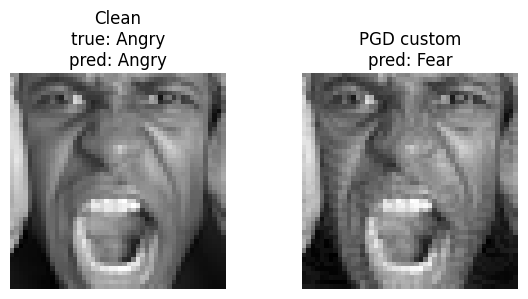

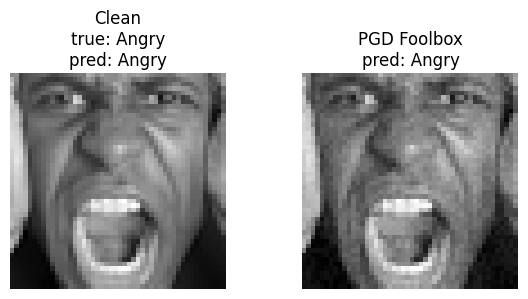

DeepFool L2 - custom vs Foolbox (same sample)


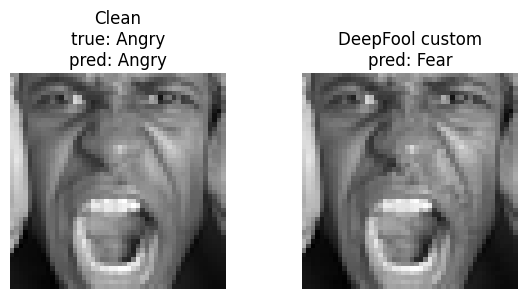

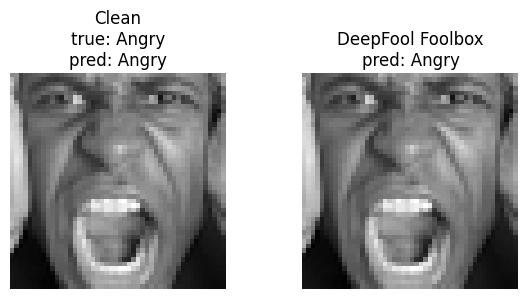

In [51]:
# CELL 20 - Exemplu vizual: PGD / DeepFool custom vs Foolbox pe aceeasi imagine

idx = np.random.randint(0, X_sub.shape[0])

x = X_sub[idx:idx+1]      
y = y_sub[idx:idx+1]   
label_int = y_sub_int[idx:idx+1]

# 1) ATACURI CUSTOM pe acest sample
x_pgd_custom = pgd_attack(
    baseline_model,
    x,
    y,
    epsilon=eps_pgd,
    alpha=0.007,
    num_iter=40
)

x_df_custom = deepfool_l2(
    baseline_model,
    x,
    overshoot=0.02,
    max_iter=5
)

# 2) ATACURI FOOLBOX pe acelasi sample
x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
label_tf = tf.convert_to_tensor(label_int, dtype=tf.int64)

_, x_pgd_fb_1, _ = attack_pgd_fb(
    fmodel_baseline,
    x_tf,
    label_tf,
    epsilons=eps_pgd
)

_, x_df_fb_1, _ = attack_df_fb(
    fmodel_baseline,
    x_tf,
    label_tf,
    epsilons=eps_df
)

x_pgd_fb_1 = fb_to_numpy(x_pgd_fb_1, dtype="float32")
x_df_fb_1 = fb_to_numpy(x_df_fb_1, dtype="float32")

# 3) AFISARE: acum toate sunt pe aceeasi imagine 'x'

print("PGD - custom vs Foolbox (same sample)")
show_original_and_adversarial(
    baseline_model, x, y, x_pgd_custom,
    title_adv="PGD custom"
)
show_original_and_adversarial(
    baseline_model, x, y, x_pgd_fb_1,
    title_adv="PGD Foolbox"
)

print("DeepFool L2 - custom vs Foolbox (same sample)")
show_original_and_adversarial(
    baseline_model, x, y, x_df_custom,
    title_adv="DeepFool custom"
)
show_original_and_adversarial(
    baseline_model, x, y, x_df_fb_1,
    title_adv="DeepFool Foolbox"
)
